I ended up doing most of my work on my local computer's GPU because I have a 3080 and Colab likes to timeout so no timepout by using my GPU. I put a good 60 computational hours into this case study on that poor GPU so hopefully that work shows in the end model. 

A few things I tested that I forgot to save the code for were: 

Learning Rate Schedules and Adaptive Learning Rates (with this study it dint help much because I think the data was pretty clean with no major local minima)

I also tested two different ways to save the model as well as 3 different ways to tune hyperparameters which took the most time. 

I wasnt able to get SHAP working to itsfull p[otential although I figured out how to have it check on only a portion of the data to save TONS of time, this was mainly for looking at individual feature importance because I am not very good at it yet and all of the tutorials were for categorical neural networks.

# Important Code 

## (While the way I did this makes sense to me and was organized according to my ADHD brain I am sorry if it is tough to follow)

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [ ]:
bikes["month"] = bikes.dteday.str.split('/').str[0]
bikes["day"] = bikes.dteday.str.split('/').str[1]
bikes["year"] = bikes.dteday.str.split('/').str[2]
bikes["weekday"] = pd.to_datetime(bikes["month"]+'-'+bikes["day"]+'-'+bikes["year"])
bikes.weekday = bikes.weekday.dt.day_name()
di = {"Sunday":1,"Monday":2,"Tuesday":3,"Wednesday":4,"Thursday":5,"Friday":6,"Saturday":7}
bikes = bikes.replace({"weekday": di})
bikes["weekday"] = bikes["weekday"].astype(np.int64)
bikes["month"] = bikes["month"].astype(np.int64)
bikes["Total"] = bikes.casual + bikes.registered
bikes = bikes.drop("dteday", 1)
bikes = bikes.drop("year", 1)
bikes = bikes.drop("day", 1)
bikes = bikes.drop("registered", 1)
bikes = bikes.drop("casual", 1)

In [ ]:
X = bikes.loc[:, bikes.columns != 'Total']
y = bikes['Total'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)

(11645, 11)
(4992, 11)


In [ ]:
print(X_train)

       season  hr  holiday  workingday  ...  temp_c  feels_like_c  month  weekday
7621        4   4        0           0  ...    4.22       -0.9982     11        7
9416        1   6        0           1  ...    8.92        9.0008      2        5
8139        4  19        0           0  ...    4.22       -0.0016     12        7
250         1  19        0           1  ...   -0.48       -0.9982      1        3
4581        3  19        0           1  ...   25.84       26.9990      7        5
...       ...  ..      ...         ...  ...     ...           ...    ...      ...
11532       2  17        0           1  ...   18.32       18.9998      4        2
16065       4   2        0           1  ...    5.16        1.0016     11        4
14501       3  10        0           0  ...   28.66       32.0018      9        7
14555       3  16        1           0  ...   26.78       30.0020      9        2
11590       2   3        0           1  ...   13.62       13.9970      5        5

[11645 rows x 1

In [ ]:
MinMaxScaler1 = MinMaxScaler()
MinMaxScaler2 = MinMaxScaler()
StandardScaler = StandardScaler()
# fit scaler
MinMaxScaler1.fit(X_train)
# transform training dataset
X_train = MinMaxScaler1.transform(X_train)
# transform test dataset
X_test = MinMaxScaler1.transform(X_test)






# reshape 1d arrays to 2d arrays
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
# fit scaler on training dataset

MinMaxScaler2.fit(y_train)
y_train = MinMaxScaler2.transform(y_train)

StandardScaler.fit(y_train)

y_train = StandardScaler.transform(y_train)

y_test = MinMaxScaler2.transform(y_test)
y_test = StandardScaler.transform(y_test)
#learn_rate': 0.0001, 'layers3': 10, 'layers2': 1000, 'layers1': 1000, 'epochs': 100, 'delta': 1, 'batch_size': 32, 'activation': 'linear'}

In [ ]:
print(y_test)

[[-0.22232726]
 [ 1.54289944]
 [ 0.52323432]
 ...
 [-0.61703634]
 [ 2.42003071]
 [-0.87469365]]


In [ ]:
inv_y_test = StandardScaler.inverse_transform(y_test)
inv_y_test2 = MinMaxScaler2.inverse_transform(inv_y_test)
print(inv_y_test2)

[[150.]
 [472.]
 [286.]
 ...
 [ 78.]
 [632.]
 [ 31.]]


In [ ]:
# Normalized X AND Y
from keras.layers import LeakyReLU
from keras.layers import Dropout
model = Sequential()
model.add(Dense(900, input_dim=11, activation= LeakyReLU(alpha=0.1)))
model.add(Dense(200, activation= LeakyReLU(alpha=0.1)))
model.add(Dense(200, activation= LeakyReLU(alpha=0.1)))
model.add(Dense(1, activation= "linear"))

In [ ]:
tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    beta_1=0.9,
    beta_2=0.999,
    # epsilon=1e-08,
    amsgrad=False,
    name="adam"
)

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
# Normalized X and Y
from tensorflow.keras.losses import Huber

# model.compile(loss=Huber(delta=1) , optimizer="adam", metrics=[coeff_determination])
# model.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=[coeff_determination])
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(X_train, y_train, epochs=200, batch_size=32)# {'learn_rate': 0.02, 'epochs': 60, 'batch_size': 36}

Epoch 1/200
364/364 [==============================] - 3s 7ms/step - loss: 0.5396 - mean_squared_error: 0.5396
Epoch 2/200
364/364 [==============================] - 3s 7ms/step - loss: 0.3657 - mean_squared_error: 0.3657
Epoch 3/200
364/364 [==============================] - 3s 7ms/step - loss: 0.2874 - mean_squared_error: 0.2874
Epoch 4/200
364/364 [==============================] - 2s 7ms/step - loss: 0.2359 - mean_squared_error: 0.2359
Epoch 5/200
364/364 [==============================] - 2s 7ms/step - loss: 0.2254 - mean_squared_error: 0.2254
Epoch 6/200
364/364 [==============================] - 3s 7ms/step - loss: 0.2208 - mean_squared_error: 0.2208
Epoch 7/200
364/364 [==============================] - 3s 7ms/step - loss: 0.1995 - mean_squared_error: 0.1995
Epoch 8/200
364/364 [==============================] - 2s 6ms/step - loss: 0.1964 - mean_squared_error: 0.1964
Epoch 9/200
364/364 [==============================] - 2s 7ms/step - loss: 0.1975 - mean_squared_error: 0.1975
E

RMSE on Test: 61.59907121370075
MSE on Test: 3794.4455743905764
MAE on Test: 39.70671615666614
R2 score on Test: 0.8843115777584498
R2 score on Test: 0.8843115801701356


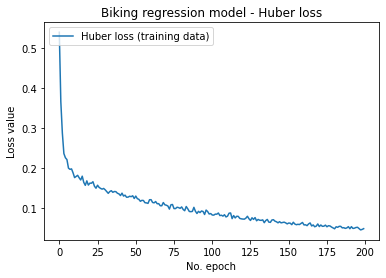

In [ ]:
#Both Normalized with best normalizers (I tested both minmax and standard for both and what you see above was the best configuration)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

y_pred = model.predict(X_test)

inv_y_pred = StandardScaler.inverse_transform(y_pred.reshape(-1, 1))
inv_y_pred2 = MinMaxScaler2.inverse_transform(inv_y_pred)
inv_y_test = StandardScaler.inverse_transform(y_test.reshape(-1, 1))
inv_y_test2 = MinMaxScaler2.inverse_transform(inv_y_test)
mse_test = mean_squared_error(inv_y_test2, inv_y_pred2)
print("RMSE on Test:", np.sqrt(mse_test))
print("MSE on Test:", mse_test)

mae_test = mean_absolute_error(inv_y_test2, inv_y_pred2)
print("MAE on Test:", mae_test)

r2 = r2_score(inv_y_test2, inv_y_pred2)
print("R2 score on Test:", r2)


r2 = r2_score(y_test, y_pred)
print("R2 score on Test:", r2)

# Plot history: Huber loss and MAE
plt.plot(history.history['loss'], label='Huber loss (training data)')
plt.title('Biking regression model - Huber loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

# plt.title('Biking regression model - MAE')
# # plt.plot(history.history['mean_squared_error'], label='MAE (training data)')
# plt.plot(history.history['coeff_determination'], label='MAE (training data)')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# plt.title('Biking regression model - MAE')
# # plt.plot(history.history['mean_squared_error'], label='MAE (training data)')
# plt.plot(history.history['coeff_determination'], label='MAE (training data)')
# plt.ylabel('Loss value')
# plt.xlabel('No. epoch')
# plt.legend(loc="upper left")
# plt.show()

In [ ]:
# !pip install shap


In [ ]:
# import shap
# data = shap.sample(X_train, 45)
# features = X.columns
# explainer = shap.KernelExplainer(model.predict,data)
# shap_values = explainer.shap_values(X_test,nsamples=100)
# # shap_values = e.shap_values(X_test,nsamples=100)


In [ ]:
# shap.summary_plot(shap_values,X_test,feature_names=features) 

In [ ]:
# shap.initjs()
# shap.force_plot(explainer, shap_values[0,:]  ,X_test[0,:],feature_names=features)

In [ ]:
# shap.summary_plot(shap_values[0], data, feature_names=features)

In [ ]:
# shap.summary_plot(shap_values,X_test,feature_names=features)
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0,:]  ,X_test[0,:],feature_names=features) 

In [ ]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values[0]  ,data,feature_names=features)

In [ ]:
y_test_pred = model.predict(X_test)
inv_y_test_pred = StandardScaler.inverse_transform(y_test_pred)
inv_y_test_pred2 = MinMaxScaler2.inverse_transform(inv_y_test_pred)
print(inv_y_test_pred2)

[[136.00383]
 [524.9146 ]
 [333.44757]
 ...
 [ 98.72937]
 [677.5899 ]
 [ 29.25757]]


In [ ]:
np.savetxt("biking_data_predictions_pred.csv", inv_y_pred2, delimiter=",")
np.savetxt("biking_data_predictions_test.csv", inv_y_test2, delimiter=",")

In [ ]:
import pandas as pd
new_data = pd.read_csv("https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes_december.csv")
new_data["month"] = new_data.dteday.str.split('/').str[0]
new_data["day"] = new_data.dteday.str.split('/').str[1]
new_data["year"] = new_data.dteday.str.split('/').str[2]
new_data["weekday"] = pd.to_datetime(new_data["month"]+'-'+new_data["day"]+'-'+new_data["year"])
new_data.weekday = new_data.weekday.dt.day_name()
di = {"Sunday":1,"Monday":2,"Tuesday":3,"Wednesday":4,"Thursday":5,"Friday":6,"Saturday":7}
new_data = new_data.replace({"weekday": di})
new_data["weekday"] = new_data["weekday"].astype(np.int64)
new_data["month"] = new_data["month"].astype(np.int64)

new_data = new_data.drop("dteday", 1)
new_data = new_data.drop("year", 1)
new_data = new_data.drop("day", 1)





# X_new1 = MinMaxScaler1.transform(new_data)

# y_pred1 = model.predict(X_new1)
# inv_y_pred1 = StandardScaler.inverse_transform(y_pred1.reshape(-1,1))


In [ ]:
X_new1 = MinMaxScaler1.transform(new_data)
y_pred1 = model.predict(X_new1)
y_pred_2 = y_pred1.reshape(len(y_pred1), 1)
# fit scaler on training dataset
# transform training dataset
inv_y_pred_3 = StandardScaler.inverse_transform(y_pred_2)
inv_y_pred_4 = MinMaxScaler2.inverse_transform(inv_y_pred_3)
print(inv_y_pred_4)
np.savetxt("biking_december_predictions.csv", inv_y_pred_4, delimiter=",")

[[ 6.65472031e+01]
 [ 4.78871078e+01]
 [ 3.08057995e+01]
 [ 2.69956722e+01]
 [ 7.19622278e+00]
 [ 6.94811010e+00]
 [ 8.50972176e+00]
 [ 1.85350590e+01]
 [ 3.15346775e+01]
 [ 3.87229080e+01]
 [ 8.52313080e+01]
 [ 1.57604095e+02]
 [ 1.43145554e+02]
 [ 1.54871841e+02]
 [ 1.66140656e+02]
 [ 1.95344849e+02]
 [ 1.75940659e+02]
 [ 1.56086517e+02]
 [ 1.32332825e+02]
 [ 1.07688934e+02]
 [ 1.30476990e+02]
 [ 6.63340378e+01]
 [ 6.24592171e+01]
 [ 8.34755554e+01]
 [ 1.06637321e+02]
 [ 9.18502808e+01]
 [ 6.49860229e+01]
 [ 3.53821411e+01]
 [ 2.51745300e+01]
 [ 2.35612030e+01]
 [ 1.50997305e+01]
 [ 2.16784687e+01]
 [ 2.53534603e+01]
 [ 4.67212105e+01]
 [ 1.21531113e+02]
 [ 2.19110321e+02]
 [ 2.19093826e+02]
 [ 3.90163544e+02]
 [ 3.88930756e+02]
 [ 3.19300903e+02]
 [ 2.56330872e+02]
 [ 1.67331299e+02]
 [ 1.97334518e+02]
 [ 1.37463455e+02]
 [ 1.19054764e+02]
 [ 1.01960800e+02]
 [ 8.30127258e+01]
 [ 5.75536270e+01]
 [ 3.05630093e+01]
 [ 1.74583721e+01]
 [ 1.07612782e+01]
 [ 8.33300304e+00]
 [ 1.0499684

In [ ]:
print(X_test)

[[0.66666667 0.         0.         ... 0.5909     0.72727273 1.        ]
 [0.66666667 0.7826087  0.         ... 0.8333     0.54545455 0.16666667]
 [0.33333333 0.47826087 0.         ... 0.6212     0.45454545 0.83333333]
 ...
 [0.         0.73913043 0.         ... 0.2121     0.09090909 1.        ]
 [0.33333333 0.7826087  0.         ... 0.4848     0.27272727 0.33333333]
 [0.33333333 0.2173913  0.         ... 0.5303     0.45454545 0.16666667]]


In [ ]:
np.savetxt("new_biking_data_predictions.csv", inv_y_pred1, delimiter=",")

In [ ]:
# new_X_test = MinMaxScaler1.transform(X_new)

This below is one of the ways I did hyperparameter tuning. I also tried a few libraries but this was a decent result. The only downside to grid or random searches is you cant run your GPU CUDA cores parallel and test fater. You can only use one core. 

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Keras specific
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
bikes = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/bikes.csv')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# import sys
import numpy as np
import tensorflow as tf
from datetime import datetime

# device_name = sys.argv[1]  # Choose device from cmd line. Options: gpu or cpu
# shape = (int(sys.argv[2]), int(sys.argv[2]))
# if device_name == "gpu":
#     device_name = "/gpu:0"
# else:
#     device_name = "/cpu:0"

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.set_logical_device_configuration(
#         gpus[0],
#         [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
#     logical_gpus = tf.config.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)
physical_devices = tf.config.list_physical_devices('GPU') # This took me way too long to figure out for running onmy ocmputer but it works great now.
try:
  tf.config.set_logical_device_configuration(
    physical_devices[0],
    tf.config.LogicalDeviceConfiguration(memory_limit=4096))

  logical_devices = tf.config.list_logical_devices('GPU')
  assert len(logical_devices) == len(physical_devices) + 1

  tf.config.set_logical_device_configuration(
    physical_devices[0],
    tf.config.LogicalDeviceConfiguration(memory_limit=4096))
except:
#   # Invalid device or cannot modify logical devices once initialized.
  pass
bikes["month"] = bikes.dteday.str.split('/').str[0]
bikes["day"] = bikes.dteday.str.split('/').str[1]
bikes["year"] = bikes.dteday.str.split('/').str[2]
bikes["weekday"] = pd.to_datetime(bikes["month"]+'-'+bikes["day"]+'-'+bikes["year"])
bikes.weekday = bikes.weekday.dt.day_name()
di = {"Sunday":1,"Monday":2,"Tuesday":3,"Wednesday":4,"Thursday":5,"Friday":6,"Saturday":7}
bikes = bikes.replace({"weekday": di})
bikes["weekday"] = bikes["weekday"].astype(np.int64)
bikes["month"] = bikes["month"].astype(np.int64)
bikes["Total"] = bikes.casual + bikes.registered
bikes = bikes.drop("dteday", 1)
bikes = bikes.drop("year", 1)
bikes = bikes.drop("day", 1)
bikes = bikes.drop("registered", 1)
bikes = bikes.drop("casual", 1)

X = bikes.loc[:, bikes.columns != 'Total']
y = bikes['Total'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=40)
print(X_train.shape); print(X_test.shape)


MinMaxScaler1 = MinMaxScaler()
MinMaxScaler2 = MinMaxScaler()
StandardScaler = StandardScaler()
# fit scaler
MinMaxScaler1.fit(X_train)
# transform training dataset
X_train = MinMaxScaler1.transform(X_train)
# transform test dataset
X_test = MinMaxScaler1.transform(X_test)

# reshape 1d arrays to 2d arrays
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)
# fit scaler on training dataset
StandardScaler.fit(y_train)
# transform training dataset
y_train = StandardScaler.transform(y_train)
# transform test dataset
y_test = StandardScaler.transform(y_test)


from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.losses import Huber
def create_model(learn_rate,layers1,layers2,layers3,delta):

    model = Sequential()
    model.add(Dense(layers1, input_dim=11, activation= "relu"))
    model.add(Dense(layers2, activation= "relu"))
    model.add(Dense(layers3, activation= "relu"))
    model.add(Dense(1, activation = 'linear'))

    adam = Adam(learning_rate=learn_rate)
    model.compile(loss=Huber(delta=delta) , optimizer=adam, metrics="mean_absolute_error")
    return model

model = KerasRegressor(build_fn=create_model, verbose=10)

learn_rate = [0.001, 0.02,.01,.0001,.0002,.0003,.00001]
epochs = [60,80,100,200,300]
layers1 = [11,22,121,500, 600,800,900,1000,1200]
layers2 = [11,22,121,33,1000, 800,500,300,200,100]
layers3 = [22,33,44,50,500,300,200,100,11,10]
delta = [1]


param_grid = dict(learn_rate=learn_rate, epochs=epochs, layers1=layers1, layers2=layers2, layers3=layers3,delta=delta)


grid = RandomizedSearchCV(estimator=model, param_distributions = param_grid, 
                scoring='neg_mean_absolute_error', 
                verbose=10,
                n_iter = 100,n_jobs=1)

grid_results = grid.fit(X_test, y_test)


print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))



# Tests (Its a little chaotic down there, welcome to my thinking processes)

In [ ]:
bikes.head()

,dteday,season,hr,holiday,workingday,weathersit,hum,windspeed,temp_c,feels_like_c,casual,registered
0,1/1/11,1,0,0,0,1,0.81,0,3.28,3.0014,3,13
1,1/1/11,1,1,0,0,1,0.80,0,2.34,1.9982,8,32
2,1/1/11,1,2,0,0,1,0.80,0,2.34,1.9982,5,27
3,1/1/11,1,3,0,0,1,0.75,0,3.28,3.0014,3,10
4,1/1/11,1,4,0,0,1,0.75,0,3.28,3.0014,0,1


In [ ]:
print(bikes.shape)

(16637, 12)


In [ ]:
min_max_scaler = MinMaxScaler()

In [ ]:
# bikes[["season", "hr","holiday", "workingday","weathersit","hum","windspeed","temp_c","feels_like_c", "month","weekday"]] = min_max_scaler.fit_transform(bikes[["season", "hr","holiday", "workingday","weathersit","hum","windspeed","temp_c","feels_like_c", "month","weekday"]])

In [ ]:
print(bikes.shape)

(16637, 12)


In [ ]:
Best: -55.424413218734756, using {'learn_rate': 0.02, 'epochs': 60, 'batch_size': 36}

In [ ]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.losses import Huber
def create_model(learn_rate,layers1,layers2,layers3,activation,delta):

  model = Sequential()
  model.add(Dense(layers1, input_dim=11, activation= "relu"))
  model.add(Dense(layers2, activation= "relu"))
  model.add(Dense(layers3, activation= "relu"))
  model.add(Dense(1, activation = activation))

  adam = Adam(learning_rate=learn_rate)
  model.compile(loss=Huber(delta=delta) , optimizer=adam, metrics="mean_absolute_error")
  return model

model = KerasRegressor(build_fn=create_model, verbose=10)

learn_rate = [0.001, 0.02, 0.2,.1,.01,.0001,.00001]
batch_size = [10,20, 30,32,36,40,50]
epochs = [20,30,50,60,80,100]
layers1 = [500, 600,800,900,1000,1200]
layers2 = [1000, 800,500,300,200,100]
layers3 = [500,300,200,100,50,11,10]
delta = [.5,1,1.2,1.35,1.5,2]
activation = ["linear", "sigmoid", "relu", "softmax"]
seed = 42


param_grid = dict(learn_rate=learn_rate, batch_size=batch_size, epochs=epochs, layers1=layers1, layers2=layers2, layers3=layers3, activation=activation,delta=delta)


grid = RandomizedSearchCV(estimator=model, param_distributions = param_grid, 
                   scoring='neg_mean_absolute_error', 
                   verbose=10,
                   n_iter = 100,n_jobs=-1)

grid_results = grid.fit(X_test, y_test)


print("Best: {0}, using {1}".format(grid_results.best_score_, grid_results.best_params_))

means = grid_results.cv_results_['mean_test_score']
stds = grid_results.cv_results_['std_test_score']
params = grid_results.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print('{0} ({1}) with: {2}'.format(mean, stdev, param))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 27.2min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 32.7min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 56.0min


In [ ]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
tf.saved_model.save(model, '/content/drive/My Drive/ColabData')

In [ ]:
# model = Sequential()
# model.add(Dense(500, input_dim=11, activation= "relu"))
# model.add(Dense(100, activation= "relu"))
# model.add(Dense(50, activation= "relu"))
# model.add(Dense(1, activation = 'linear'))

In [ ]:
model = Sequential()
model.add(Dense(1000, input_dim=11, activation= "relu"))
model.add(Dense(100, activation= "relu"))
model.add(Dense(50, activation= "relu"))
model.add(Dense(1, activation = 'linear'))

In [ ]:
# Non-Normalized or standardized X or Y
model3 = Sequential()
model3.add(Dense(1000, input_dim=11, activation= "relu"))
model3.add(Dense(100, activation= "relu"))
model3.add(Dense(50, activation= "relu"))
model3.add(Dense(1, activation = 'linear'))

In [ ]:
# Normalized X AND Y
model4 = Sequential()
model4.add(Dense(800, input_dim=11, activation= "relu"))
model4.add(Dense(100, activation= "relu"))
model4.add(Dense(50, activation= "relu"))
model4.add(Dense(1))

In [ ]:
# Best: -55.424413218734756, using {'learn_rate': 0.02, 'epochs': 60, 'batch_size': 36}

In [ ]:
tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    # epsilon=1e-08,
    amsgrad=False,
    name="adam"
)

In [ ]:
# Non-Normalized X or Y
from tensorflow.keras.losses import Huber

model4.compile(loss=Huber(delta=1.35) , optimizer="adam", metrics="mean_absolute_error")
# model.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=[coeff_determination])
# model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history4 = model4.fit(X_train, y_train, epochs=120, batch_size=33)# {'learn_rate': 0.02, 'epochs': 60, 'batch_size': 36}

Epoch 1/120
353/353 [==============================] - 2s 4ms/step - loss: 0.0380 - mean_absolute_error: 0.1814
Epoch 2/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0375 - mean_absolute_error: 0.1799
Epoch 3/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0392 - mean_absolute_error: 0.1845
Epoch 4/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0371 - mean_absolute_error: 0.1800
Epoch 5/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0367 - mean_absolute_error: 0.1785
Epoch 6/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0359 - mean_absolute_error: 0.1756
Epoch 7/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0375 - mean_absolute_error: 0.1794
Epoch 8/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0367 - mean_absolute_error: 0.1788
Epoch 9/120
353/353 [==============================] - 1s 4ms/step - loss: 0.0362 - mean_absolute_error:

In [ ]:
# Non-Normalized X or Y
from tensorflow.keras.losses import Huber

model3.compile(loss=Huber(delta=1.35) , optimizer="adam", metrics="mean_absolute_error")
# model.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=[coeff_determination])
# model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model3.fit(X_train, y_train, epochs=250, batch_size=30)# {'learn_rate': 0.02, 'epochs': 60, 'batch_size': 36}

Epoch 1/250
389/389 [==============================] - 2s 4ms/step - loss: 135.7389 - mean_absolute_error: 101.2188
Epoch 2/250
389/389 [==============================] - 1s 4ms/step - loss: 119.9523 - mean_absolute_error: 89.5219
Epoch 3/250
389/389 [==============================] - 2s 4ms/step - loss: 115.0178 - mean_absolute_error: 85.8655
Epoch 4/250
389/389 [==============================] - 2s 4ms/step - loss: 112.0514 - mean_absolute_error: 83.6661
Epoch 5/250
389/389 [==============================] - 2s 4ms/step - loss: 109.3652 - mean_absolute_error: 81.6764
Epoch 6/250
389/389 [==============================] - 1s 4ms/step - loss: 107.4305 - mean_absolute_error: 80.2434
Epoch 7/250
389/389 [==============================] - 2s 4ms/step - loss: 104.7304 - mean_absolute_error: 78.2420
Epoch 8/250
389/389 [==============================] - 2s 4ms/step - loss: 103.0129 - mean_absolute_error: 76.9692
Epoch 9/250
389/389 [==============================] - 2s 4ms/step - loss: 100.

In [ ]:
from tensorflow.keras.losses import Huber

model.compile(loss=Huber(delta=1.35) , optimizer="adam", metrics=[coe])
# model.compile(loss= "mean_absolute_error" , optimizer="adam", metrics=[coeff_determination])
# model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history = model.fit(X_train, y_train, epochs=250, batch_size=30)# {'learn_rate': 0.02, 'epochs': 60, 'batch_size': 36}

Epoch 1/250
389/389 [==============================] - 2s 4ms/step - loss: 40.7260 - mean_absolute_error: 30.8209
Epoch 2/250
389/389 [==============================] - 2s 4ms/step - loss: 40.1770 - mean_absolute_error: 30.4165
Epoch 3/250
389/389 [==============================] - 1s 4ms/step - loss: 40.7172 - mean_absolute_error: 30.8142
Epoch 4/250
389/389 [==============================] - 2s 4ms/step - loss: 39.7748 - mean_absolute_error: 30.1153
Epoch 5/250
389/389 [==============================] - 1s 4ms/step - loss: 40.0183 - mean_absolute_error: 30.2965
Epoch 6/250
389/389 [==============================] - 1s 4ms/step - loss: 39.3965 - mean_absolute_error: 29.8371
Epoch 7/250
389/389 [==============================] - 1s 4ms/step - loss: 40.1744 - mean_absolute_error: 30.4132
Epoch 8/250
389/389 [==============================] - 2s 4ms/step - loss: 39.8030 - mean_absolute_error: 30.1365
Epoch 9/250
389/389 [==============================] - 2s 4ms/step - loss: 39.8872 - mea

RMSE on Test: 66.39611388607847
MSE on Test: 4408.443939173101
MAE on Test: 45.070183584765076
R2 score on Test: 0.8655914510131899


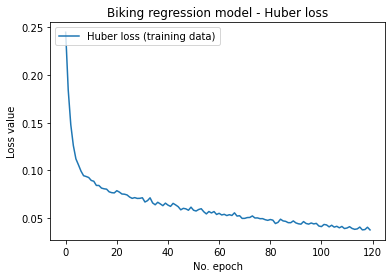

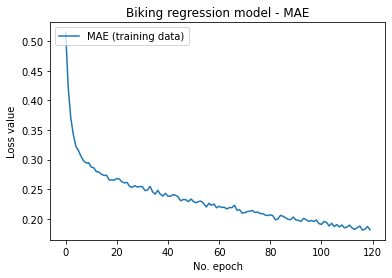

In [ ]:
#Both Normalized with best normalizers (I tested both minmax and standard for both and what you see above was the best configuration)
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
inv_y_pred = model4.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# print("non inverted R2 score on Test:", r2)
# mse_test = mean_squared_error(y_test, inv_y_pred)


# mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
# print("MAE on Test:", mae_test)
# print("RMSE on Test:", np.sqrt(mse_test))
# print("MSE on Test:", mse_test)

# mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
# print("MAE on Test:", mae_test)

inv_y_pred = StandardScaler.inverse_transform(y_pred.reshape(-1, 1))
inv_y_test = StandardScaler.inverse_transform(y_test.reshape(-1, 1))

mse_test = mean_squared_error(inv_y_test, inv_y_pred)
print("RMSE on Test:", np.sqrt(mse_test))
print("MSE on Test:", mse_test)

mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
print("MAE on Test:", mae_test)

r2 = r2_score(inv_y_test, inv_y_pred)
print("R2 score on Test:", r2)

# Plot history: Huber loss and MAE
plt.plot(history4.history['loss'], label='Huber loss (training data)')
plt.title('Biking regression model - Huber loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.title('Biking regression model - MAE')
plt.plot(history4.history['mean_absolute_error'], label='MAE (training data)')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

non inverted R2 score on Test: 0.8456888079228588
MAE on Test: 44.63066609671865
RMSE on Test: 71.14230431665669
MSE on Test: 5061.2274634837895


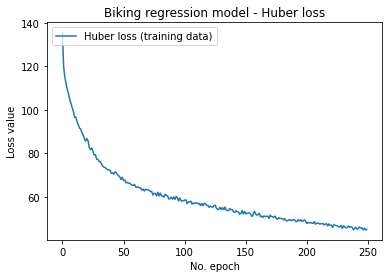

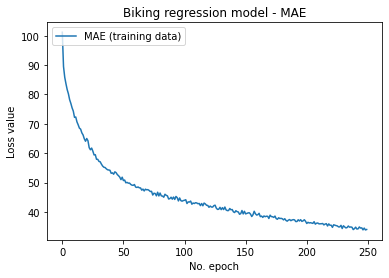

In [ ]:
# Non-Normalized X and Y
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
y_pred = model3.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("non inverted R2 score on Test:", r2)
mse_test = mean_squared_error(y_test, y_pred)


mae_test = mean_absolute_error(y_test, y_pred)
print("MAE on Test:", mae_test)
print("RMSE on Test:", np.sqrt(mse_test))
print("MSE on Test:", mse_test)

# mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
# print("MAE on Test:", mae_test)

# inv_y_pred = StandardScaler.inverse_transform(y_pred.reshape(-1, 1))
# inv_y_test = StandardScaler.inverse_transform(y_test.reshape(-1, 1))

# mse_test = mean_squared_error(inv_y_test, inv_y_pred)
# print("RMSE on Test:", np.sqrt(mse_test))
# print("MSE on Test:", mse_test)

# mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
# print("MAE on Test:", mae_test)

# r2 = r2_score(inv_y_test, inv_y_pred)
# print("R2 score on Test:", r2)

# r2 = r2_score(y_test, y_pred)
# print("non inverted R2 score on Test:", r2)
# Plot history: Huber loss and MAE
plt.plot(history.history['loss'], label='Huber loss (training data)')
plt.title('Biking regression model - Huber loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.title('Biking regression model - MAE')
plt.plot(history.history['mean_absolute_error'], label='MAE (training data)')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

non inverted R2 score on Test: -71213.03470831638
MAE on Test: 40.240808777470825
RMSE on Test: 256.17626090127527
MSE on Test: 65626.27664935825


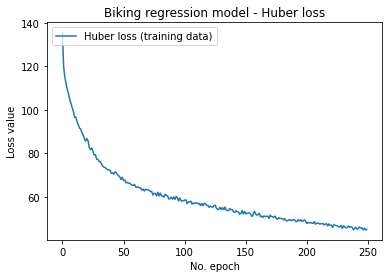

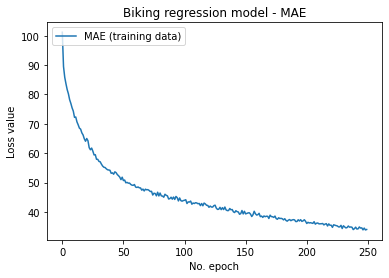

In [ ]:
# Normalized X but not normalized Y

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("non inverted R2 score on Test:", r2)
mse_test = mean_squared_error(y_test, inv_y_pred)


mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
print("MAE on Test:", mae_test)
print("RMSE on Test:", np.sqrt(mse_test))
print("MSE on Test:", mse_test)

# mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
# print("MAE on Test:", mae_test)

# inv_y_pred = StandardScaler.inverse_transform(y_pred.reshape(-1, 1))
# inv_y_test = StandardScaler.inverse_transform(y_test.reshape(-1, 1))

# mse_test = mean_squared_error(inv_y_test, inv_y_pred)
# print("RMSE on Test:", np.sqrt(mse_test))
# print("MSE on Test:", mse_test)

# mae_test = mean_absolute_error(inv_y_test, inv_y_pred)
# print("MAE on Test:", mae_test)

# r2 = r2_score(inv_y_test, inv_y_pred)
# print("R2 score on Test:", r2)

# r2 = r2_score(y_test, y_pred)
# print("non inverted R2 score on Test:", r2)
# Plot history: Huber loss and MAE
plt.plot(history.history['loss'], label='Huber loss (training data)')
plt.title('Biking regression model - Huber loss')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

plt.title('Biking regression model - MAE')
plt.plot(history.history['mean_absolute_error'], label='MAE (training data)')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [ ]:
from keras import backend as K

def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
i_y_train = scaler.inverse_transform(y_train)
i_pred_train = scaler.inverse_transform(pred_train)
i_y_test = scaler.inverse_transform(y_test)

In [ ]:
#mean_squared_error for loss but metrics is r^2    r^2 = 0.9143
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

48.93683055608981
64.90046428643672


In [ ]:
# mean_squared_error or loss and metrics
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

54.73985338169637
66.48694794187172


In [ ]:
# Best MAE loss 35.60 with 0.9579 r^2
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

47.441224304192176
64.05977923959267


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set

In [ ]:
# reduce to 1d array
# yhat_probs = yhat_probs[:, 0]

In [ ]:
# %ls


In [ ]:
model.save('/content/drive/MyDrive/STUDY4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/STUDY4/assets


In [ ]:

# # accuracy: (tp + tn) / (p + n)
# accuracy = accuracy_score(y_test, yhat_classes)
# print('Accuracy: %f' % accuracy)
# # precision tp / (tp + fp)
# precision = precision_score(y_test, yhat_classes)
# print('Precision: %f' % precision)
# # recall: tp / (tp + fn)
# recall = recall_score(y_test, yhat_classes)
# print('Recall: %f' % recall)
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(y_test, yhat_classes)
# print('F1 score: %f' % f1)